## Setting

### Optional

In [1]:
!pip install xgboost lightgbm catboost -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 135.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 13.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
root = "/content/drive/MyDrive/Machine Learning/"
import sys
sys.path.append(root)

### Required

In [4]:
from close.train_tuning import Model
from close.evaluation import show_confusion_matrix, per_class_accuracy, overall_metrics, top_k_accuracy, confidence_analysis

is_binary = False

## Loading Data

In [5]:
import pickle
import pandas as pd

use_original_data = False

# Load the pickle file
print("Loading datafile...")
with open(f"{root}data/preprocess_data_33/close_train_33.pkl", "rb") as f:
    train = pickle.load(f)
    X_train = pd.DataFrame(train["X"])
    X_train.columns = train["feature_names"]
    y_train = train["y"]
with open(f"{root}data/preprocess_data_33/close_val_33.pkl", "rb") as f:
    val = pickle.load(f)
    X_val = pd.DataFrame(val["X"])
    X_val.columns = val["feature_names"]
    y_val = val["y"]

if use_original_data:
  X_train = train['scaler'].inverse_transform(train['X'])
  X_train = pd.DataFrame(X_train)
  X_train.columns = train['feature_names']

  X_val = val['scaler'].inverse_transform(val['X'])
  X_val = pd.DataFrame(X_val)
  X_val.columns = val['feature_names']

print("Loading complete.")
print("Training data size:\t", len(X_train))
print("Validation data size:\t", len(X_val))

Loading datafile...
Loading complete.
Training data size:	 13300
Validation data size:	 2850


## Model

CATboost

In [6]:
model_type = "cat"
param_grid = {
    "n_estimators": [100, 200],      # 2
    "max_depth": [5, 10],            # 2
    "learning_rate": [0.1],          # 1
    "subsample": [1.0],              # 1
}


### Base Model Training

get feature importance and generate feature combinations

In [7]:
import numpy as np

# 1) wrapper 기반 CatBoost 모델 생성 & 학습
mdl = Model(is_binary=is_binary, code="cat")
mdl.create_model("cat")
mdl.fit(X_train, y_train)

# 2) wrapper로 raw feature importance 받기
fi_raw = mdl.get_feature_importances()   # key: feature_0..., value: importance

# 3) wrapper가 반환한 feature 이름을 실제 DataFrame 컬럼명으로 매핑
mapped_fi = {}

for feat, imp in fi_raw.items():
    if feat.startswith("feature_"):   # CatBoost 스타일 feature_0, feature_1...
        idx = int(feat.split("_")[1])-1   # 0,1,2,...
        real_name = X_train.columns[idx]
        mapped_fi[real_name] = imp
    else:
        mapped_fi[feat] = imp

# 4) 중요도 정렬
fi_sorted = dict(
    sorted(mapped_fi.items(), key=lambda x: abs(x[1]), reverse=True)
)

print("=== [CAT] Feature importances (name, importance) ===")
for name, value in fi_sorted.items():
    print(f"{name:15s}  {value}")

# 5) top-k feature 조합 생성
ranked_names = list(fi_sorted.keys())

def make_feature_combinations(ranked_names, k_list):
    combos = []
    for k in k_list:
        combos.append({
            "k": k,
            "features": ranked_names[:k]
        })
    return combos

k_list = [24,29, 33]
feature_combinations = make_feature_combinations(ranked_names, k_list)

print("\n=== Generated feature combinations ===")
print(feature_combinations)


0:	learn: 3.7210945	total: 117ms	remaining: 11.6s
1:	learn: 3.3295444	total: 185ms	remaining: 9.08s
2:	learn: 2.8258550	total: 251ms	remaining: 8.11s
3:	learn: 2.5698355	total: 315ms	remaining: 7.57s
4:	learn: 2.3243463	total: 379ms	remaining: 7.2s
5:	learn: 2.1965948	total: 444ms	remaining: 6.96s
6:	learn: 2.0547179	total: 509ms	remaining: 6.76s
7:	learn: 2.0069193	total: 576ms	remaining: 6.62s
8:	learn: 1.8766823	total: 643ms	remaining: 6.5s
9:	learn: 1.8151130	total: 709ms	remaining: 6.38s
10:	learn: 1.7489755	total: 774ms	remaining: 6.26s
11:	learn: 1.6881843	total: 841ms	remaining: 6.16s
12:	learn: 1.6175631	total: 907ms	remaining: 6.07s
13:	learn: 1.5595321	total: 970ms	remaining: 5.96s
14:	learn: 1.4900028	total: 1.03s	remaining: 5.84s
15:	learn: 1.4365194	total: 1.1s	remaining: 5.75s
16:	learn: 1.3643456	total: 1.16s	remaining: 5.67s
17:	learn: 1.3346672	total: 1.23s	remaining: 5.58s
18:	learn: 1.2870352	total: 1.29s	remaining: 5.5s
19:	learn: 1.2397141	total: 1.36s	remaining: 

basemodel training

In [8]:
import numpy as np
import pandas as pd

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

results = []

for comb in feature_combinations:        # e.g. k=24, 29, 33
    k = comb["k"]
    feat_names = comb["features"]

    print(f"\n====== Testing feature subset: k={k} ======")
    print("Features:", feat_names)

    # 1) 조합에 맞게 subset 생성
    X_train_sub = X_train[feat_names]
    X_val_sub   = X_val[feat_names]

    # 2) 모델 생성 (baseline hyperparameters 사용)
    model = Model(is_binary=is_binary)
    model.create_model(model_type)      # <-- baseline default hparams 자동 적용
    print("Using baseline hparams:", model.hparams)

    # 3) 학습
    model.fit(X_train_sub, y_train)

    # 4) 성능 평가
    val_acc = model.score(X_val_sub, y_val)
    print(f"[k={k}] Val Accuracy = {val_acc:.4f}")

    # 5) K-Fold (train subset 기준)
    cv_scores = model.k_fold_cv(X_train_sub, y_train, k=5)

    # 6) 결과 저장
    results.append({
        "k": k,
        "features": feat_names,
        "val_acc": val_acc,
        "cv_mean": np.mean(cv_scores),
        "cv_scores": cv_scores.tolist(),
    })

# 7) 전체 결과 표로 확인
results_df = pd.DataFrame(results).sort_values(by="val_acc", ascending=False)
print("\n=== Summary (baseline hparams, feature subsets) ===")
print(results_df)



====== Testing feature subset: k=24 ======
Features: ['burst_max_first30', 'burst_count', 'ratio_out', 'num_in', 'duration', 'burst_std_first30', 'burst_count_first30', 'out_first30', 'burst_ratio_in', 'burst_mean', 'frac_in', 'burst_ratio_in_first30', 'n_packets', 'std_iat', 'burst_mean_first30', 'switch_count_first30', 'num_out', 'ratio_out_first30', 'frac_in_first30', 'in_first30', 'burst_std', 'q75_iat_first30', 'switch_count', 'burst_max']
Using baseline hparams: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.3, 'subsample': 1}
0:	learn: 3.6932296	total: 57.4ms	remaining: 5.68s
1:	learn: 3.3310064	total: 114ms	remaining: 5.6s
2:	learn: 2.8593721	total: 172ms	remaining: 5.56s
3:	learn: 2.6226489	total: 235ms	remaining: 5.65s
4:	learn: 2.3536331	total: 293ms	remaining: 5.57s
5:	learn: 2.1928735	total: 353ms	remaining: 5.53s
6:	learn: 2.0843743	total: 410ms	remaining: 5.45s
7:	learn: 1.9667642	total: 469ms	remaining: 5.4s
8:	learn: 1.8115978	total: 528ms	remaining: 5.34s
9

### Feature Evaluation

In [9]:
mdl.get_feature_importances()

{'feature_31': 21.509635501078737,
 'feature_10': 9.068099526584243,
 'feature_6': 8.314733031228599,
 'feature_15': 7.952796840225941,
 'feature_8': 5.006948764578612,
 'feature_30': 5.001015552758746,
 'feature_28': 4.615391459746332,
 'feature_19': 4.492570383383232,
 'feature_14': 3.838103567496782,
 'feature_11': 3.460847722650931,
 'feature_17': 3.1762322668854557,
 'feature_32': 3.0090566077838403,
 'feature_9': 2.672648092885304,
 'feature_2': 2.4491370954999296,
 'feature_29': 2.395213049048083,
 'feature_26': 2.2552495598005353,
 'feature_16': 1.942948998728951,
 'feature_25': 1.9227473516329916,
 'feature_33': 1.7758983920768139,
 'feature_18': 1.1332763534352703,
 'feature_12': 0.91112576307263,
 'feature_24': 0.8888827940897762,
 'feature_7': 0.7888142054676694,
 'feature_13': 0.4703323431178034,
 'feature_1': 0.3499069165701882,
 'feature_20': 0.34902169112187714,
 'feature_21': 0.16846983934700338,
 'feature_27': 0.0808806513381912,
 'feature_3': 8.416196020233479e-06,
 

### Hyperparameter Tuning

In [10]:
import numpy as np
import pandas as pd

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

# === k=24 조합만 추출 ===
comb_k24 = [c for c in feature_combinations if c["k"] == 24][0]
feat_names_24 = comb_k24["features"]

print("=== GridSearch for k=24 ===")
print("Features:", feat_names_24)

# subset 생성
X_train_24 = X_train[feat_names_24]
X_val_24   = X_val[feat_names_24]

# 모델 생성
model_24 = Model(is_binary=False)
model_24.create_model("cat")

# GridSearchCV 실행
bst_24 = model_24.grid_search(X_train_24, y_train, param_grid, verbose=2)

best_model_24  = bst_24.best_estimator_
best_params_24 = bst_24.best_params_
best_cv_24     = bst_24.best_score_
val_acc_24     = best_model_24.score(X_val_24, y_val)

print("\n=== Result (k=24) ===")
print("best_cv_score:", best_cv_24)
print("val_acc      :", val_acc_24)
print("best_params  :", best_params_24)

=== GridSearch for k=24 ===
Features: ['burst_max_first30', 'burst_count', 'ratio_out', 'num_in', 'duration', 'burst_std_first30', 'burst_count_first30', 'out_first30', 'burst_ratio_in', 'burst_mean', 'frac_in', 'burst_ratio_in_first30', 'n_packets', 'std_iat', 'burst_mean_first30', 'switch_count_first30', 'num_out', 'ratio_out_first30', 'frac_in_first30', 'in_first30', 'burst_std', 'q75_iat_first30', 'switch_count', 'burst_max']
Fitting 5 folds for each of 4 candidates, totalling 20 fits
0:	learn: 4.2591617	total: 37.5ms	remaining: 3.71s
1:	learn: 3.9435288	total: 75ms	remaining: 3.67s
2:	learn: 3.7725226	total: 112ms	remaining: 3.62s
3:	learn: 3.5691359	total: 155ms	remaining: 3.71s
4:	learn: 3.4289576	total: 193ms	remaining: 3.67s
5:	learn: 3.3127268	total: 230ms	remaining: 3.6s
6:	learn: 3.2154330	total: 267ms	remaining: 3.54s
7:	learn: 3.1822644	total: 305ms	remaining: 3.5s
8:	learn: 3.0768634	total: 345ms	remaining: 3.49s
9:	learn: 2.9586080	total: 383ms	remaining: 3.45s
10:	lear

In [11]:
import numpy as np
import pandas as pd

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

# === k=29 조합만 추출 ===
comb_k29 = [c for c in feature_combinations if c["k"] == 29][0]
feat_names_29 = comb_k29["features"]

print("=== GridSearch for k=29 ===")
print("Features:", feat_names_29)

# subset 생성
X_train_29 = X_train[feat_names_29]
X_val_29   = X_val[feat_names_29]

# 모델 생성
model_29 = Model(is_binary=False)
model_29.create_model("cat")

# GridSearchCV 실행
bst_29 = model_29.grid_search(X_train_29, y_train, param_grid, verbose=2)

best_model_29  = bst_29.best_estimator_
best_params_29 = bst_29.best_params_
best_cv_29     = bst_29.best_score_
val_acc_29     = best_model_29.score(X_val_29, y_val)

print("\n=== Result (k=29) ===")
print("best_cv_score:", best_cv_29)
print("val_acc      :", val_acc_29)
print("best_params  :", best_params_29)

=== GridSearch for k=29 ===
Features: ['burst_max_first30', 'burst_count', 'ratio_out', 'num_in', 'duration', 'burst_std_first30', 'burst_count_first30', 'out_first30', 'burst_ratio_in', 'burst_mean', 'frac_in', 'burst_ratio_in_first30', 'n_packets', 'std_iat', 'burst_mean_first30', 'switch_count_first30', 'num_out', 'ratio_out_first30', 'frac_in_first30', 'in_first30', 'burst_std', 'q75_iat_first30', 'switch_count', 'burst_max', 'mean_iat', 'mean_iat_first30', 'std_iat_first30', 'duration_first30', 'median_iat']
Fitting 5 folds for each of 4 candidates, totalling 20 fits
0:	learn: 4.2693354	total: 36.9ms	remaining: 3.65s
1:	learn: 3.9898962	total: 76.6ms	remaining: 3.75s
2:	learn: 3.8138524	total: 114ms	remaining: 3.69s
3:	learn: 3.7139178	total: 152ms	remaining: 3.66s
4:	learn: 3.5135172	total: 193ms	remaining: 3.66s
5:	learn: 3.3761937	total: 234ms	remaining: 3.66s
6:	learn: 3.2788986	total: 271ms	remaining: 3.6s
7:	learn: 3.1296412	total: 310ms	remaining: 3.56s
8:	learn: 3.0326267	

In [ ]:
import numpy as np
import pandas as pd

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

# === k=33 조합만 추출 ===
comb_k33 = [c for c in feature_combinations if c["k"] == 33][0]
feat_names_33 = comb_k33["features"]

print("=== GridSearch for k=33 ===")
print("Features:", feat_names_33)

# subset 생성
X_train_33 = X_train[feat_names_33]
X_val_33   = X_val[feat_names_33]

# 모델 생성
model_33 = Model(is_binary=False)
model_33.create_model("cat")

# GridSearchCV 실행
bst_33 = model_33.grid_search(X_train_33, y_train, param_grid, verbose=2)

best_model_33  = bst_33.best_estimator_
best_params_33 = bst_33.best_params_
best_cv_33     = bst_33.best_score_
val_acc_33     = best_model_33.score(X_val_33, y_val)

print("\n=== Result (k=33) ===")
print("best_cv_score:", best_cv_33)
print("val_acc      :", val_acc_33)
print("best_params  :", best_params_33)


=== GridSearch for k=33 ===
Features: ['burst_max_first30', 'burst_count', 'ratio_out', 'num_in', 'duration', 'burst_std_first30', 'burst_count_first30', 'out_first30', 'burst_ratio_in', 'burst_mean', 'frac_in', 'burst_ratio_in_first30', 'n_packets', 'std_iat', 'burst_mean_first30', 'switch_count_first30', 'num_out', 'ratio_out_first30', 'frac_in_first30', 'in_first30', 'burst_std', 'q75_iat_first30', 'switch_count', 'burst_max', 'mean_iat', 'mean_iat_first30', 'std_iat_first30', 'duration_first30', 'median_iat', 'q75_iat', 'q25_iat', 'median_iat_first30', 'q25_iat_first30']
Fitting 5 folds for each of 4 candidates, totalling 20 fits
0:	learn: 4.2970988	total: 40.2ms	remaining: 3.98s
1:	learn: 4.0162093	total: 80.1ms	remaining: 3.92s
2:	learn: 3.7868486	total: 121ms	remaining: 3.9s
3:	learn: 3.6439383	total: 161ms	remaining: 3.86s
4:	learn: 3.4668940	total: 201ms	remaining: 3.81s
5:	learn: 3.3471243	total: 243ms	remaining: 3.8s
6:	learn: 3.2289659	total: 282ms	remaining: 3.75s
7:	learn

### Evaluation

In [ ]:
# 1) 최종 모델 및 데이터 준비
model_best = best_model_24
best_features = feat_names_24

X_val_best = X_val[best_features]
y = y_val
y_pred = model_best.predict(X_val_best)
y_prob = model_best.predict_proba(X_val_best)   # (N, n_classes)

# 2) 클래스 정보
n_classes = len(np.unique(y_train))
class_names = [str(i) for i in range(n_classes)]

In [ ]:
# 1) 최종 모델 및 데이터 준비
model_best = best_model_29
best_features = feat_names_29

X_val_best = X_val[best_features]
y = y_val
y_pred = model_best.predict(X_val_best)
y_prob = model_best.predict_proba(X_val_best)   # (N, n_classes)

# 2) 클래스 정보
n_classes = len(np.unique(y_train))
class_names = [str(i) for i in range(n_classes)]

In [ ]:
# 1) 최종 모델 및 데이터 준비
model_best = best_model_33
best_features = feat_names_33

X_val_best = X_val[best_features]
y = y_val
y_pred = model_best.predict(X_val_best)
y_prob = model_best.predict_proba(X_val_best)   # (N, n_classes)

# 2) 클래스 정보
n_classes = len(np.unique(y_train))
class_names = [str(i) for i in range(n_classes)]

1. Confusion Matrix



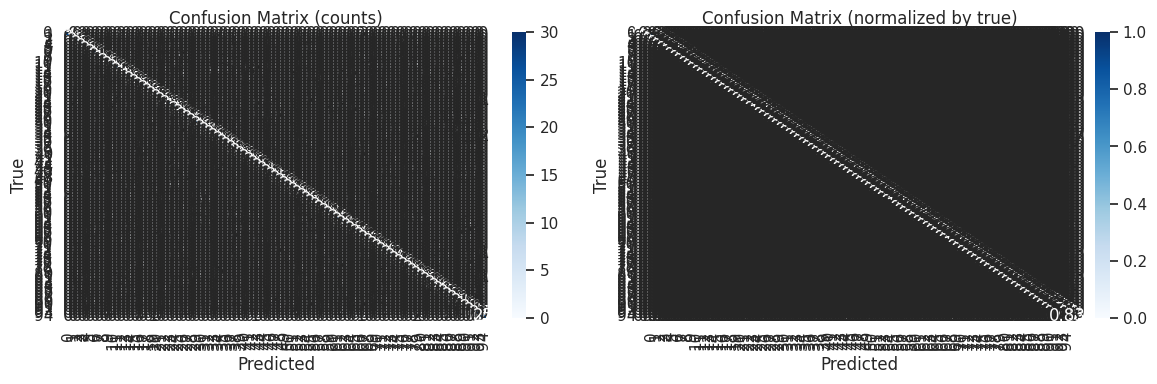

<Figure size 640x480 with 0 Axes>

In [ ]:
cm = show_confusion_matrix(y, y_pred, class_names, model_type)

2. Per-class Accuracy



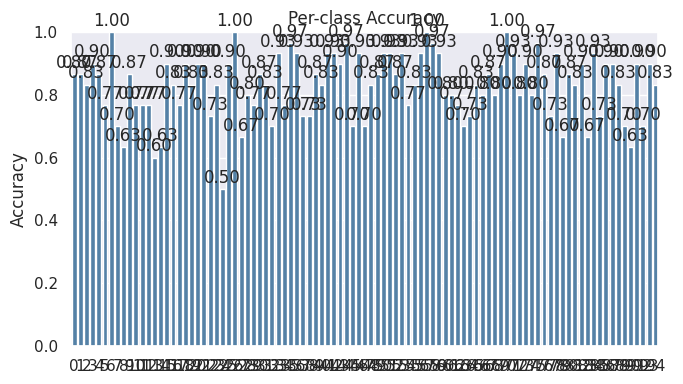

<Figure size 640x480 with 0 Axes>

In [ ]:
per_class_accuracy(cm, class_names, model_type)

In [ ]:
overall_metrics(y, y_pred, y_prob, n_classes)

3. Overall Metrics

- Accuracy: 0.8309
- Macro F1: 0.8299 (macro P=0.8348, macro R=0.8309)
- Weighted F1: 0.8299 (weighted P=0.8348, weighted R=0.8309)
- Log Loss: 0.7088


In [ ]:
top_k_accuracy(y, y_prob, n_classes)

4. Top k Accuracy

- Top-1 accuracy: 0.8309
- Top-3 accuracy: 0.9267
- Top-5 accuracy: 0.9523


In [ ]:
##confidence_analysis(y, y_pred, y_prob, model_type)

### Save Model

In [ ]:
model.save_model(model=bst_24.best_estimator_, file_name=f"{bst_24.best_params_}")

In [ ]:
model.save_model(model=bst_29.best_estimator_, file_name=f"{bst_29.best_params_}")

In [ ]:
model.save_model(model=bst_33.best_estimator_, file_name=f"{bst_33.best_params_}")